## Desafío Mercado Libre

### 4. Series de tiempo

Elaborado por : Laura Nogues

### Contenido
- [Introducción](#intro)

- [PARTE 1: EDA](#1)
- [PARTE 2: Modelado](#2)
- [PARTE 3: 21-day Forecast](#3)
- [PARTE 4: Conclusión](#4)

### Introducción <a id='intro'></a>

Pronosticar las ventas de un producto o de una categoría es un desafío recurrente
para cualquier ecommerce.
En este caso, el desafío va a ser pronosticar la cantidad de unidades diarias que van a
vender 3 categorías distintas de MELI.
El dataset “series.csv” tiene las ventas en unidades diarias de 3 categorías que
poseen un id único y su fecha de venta.


El objetivo de este desafío es construir un modelo de forecast que permita estimar las
ventas de 3 semanas a nivel diario utilizando la historia de ventas de la categoría. Es
decir, predecir las ventas de los siguientes 21 días. Las métricas y la medición de la
performance del forecast son un punto clave de este desafío.
TIP: Dividir el dataset en entrenamiento, testing y validación correctamente es muy
importante en problemas de forecasting!

_importamos las librerías a usar_

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import prophet as Phrobet
from sklearn.metrics import mean_squared_error
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import pickle
from prophet.plot import plot_plotly
from neuralprophet import set_random_seed

_importamos el dataset_

In [2]:
df= pd.read_csv('data\series.csv')

In [3]:
df.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB


Cambiamos el tipo de datos de la columna DATE de object a datetime y los ordenamos por orden cronológico.

In [42]:
df['DATE'] =  pd.to_datetime(df['DATE'])
df.sort_values('DATE', inplace= True)

### PARTE 1: EDA <a id='1'></a>
Para cononcer el historial de ventas de cada categoría y su respectivo volumen, realizaremos un análisis preliminar antes de comenzar a modelar. De esta forma podemos identificar las tendencias, ciclos y patrones de las unidades de venta para cada categoría. 

In [43]:
for category in ['CATEG-1', 'CATEG-2', 'CATEG-3']:    
    fig = px.line(df[df['CATEGORY']== category], x='DATE', y='UNITS_SOLD', title=f'Volumen de Ventas {category}', )

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    fig.show()


Para cada categoría observamos tendencias muy distintas. La CATEG-1 se caracteriza por cierta seasonality ya que cada mes de noviembre y mayo observamos un pico en la cantidad de unidades vendidas,mientras que en los meses intermedios el volumen de ventas disminuye. Es decir, se identifican tedencias ciclicas de crecimiento y decrecimiento. Asimismo, en el último mes observamos una tendencia creciente de ventas. 

Para la segunda categoría, observamos un pico en las ventas durante el inicio de abril del 2020, pero luego la curva se vuelve estacionaria disminuyendo sus ventas en gran medida, volviendo a los valores de principios del 2019. Un año mas tarde, para marzo del 2021,  observamos otro aumento en el volumen de unidades vendidas ,aunque menor que el primero,que luego se estabiliza retornando a los valores normales. 

En la CATEG-3 observamos una tendencia creciente para el último mes, y una tendencia general de crecimiento en las unidades de venta. Nuevamente, los meses de mayo y noviembre se caracterizan por un aumento significativo, que se observa en los picos de la gráfica. Por lo que se identifican tendencias de crecimiento ciclicas que responden a las epocas y momentos del año, y a su vez estan incrementan con cada ciclo. 

##### Separamos el dataset por cada producto 

In [44]:
def crear_dataset(df, category): 
    df= df[df['CATEGORY']==category]
    df.rename(columns = {'DATE': 'ds', 
                         'UNITS_SOLD': 'y'}, inplace = True)
    df.drop(columns='CATEGORY', inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns= 'index', inplace= True)
    return df

In [45]:
df_1= crear_dataset(df, 'CATEG-1')
df_2= crear_dataset(df, 'CATEG-2')
df_3= crear_dataset(df, 'CATEG-3')

WARNING - (py.warnings._showwarnmsg) - C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21064\4026347412.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21064\4026347412.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21064\4026347412.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

### PARTE 2 Modelado <a id='2'></a>

El modelo elegido para predecir las unidades de venta es Neural Prophet, un modelo de Facebook en fase beta que une las características del modelo lanzado en 2017, Prophet, con los beneficios de una red neuronal, sin convertirse en un modelo de caja negra. No solo introduce modelos como ARNet, sino que identifica tendencias, ciclos y eventos recurrentes a la hora de modelar. Es posible modificar mayor cantidad de parámetros que con el modelo anterior Phrobet y permite acceder a las facilidades que brindan las redes neuronales. Al igual que Phrophet, brinda un análisis de los componentes del modelo que permite comprender las tendencias, ciclos y la información que el modelo obtuvo para modelar. Estos análisis permiten comprender mejor los datos y de que forma se comportan en el tiempo. 

Considerando el volumen de datos para cada categoría este modelo logra identificar las relaciones intrínsicas entre ellos, obteniendo mejores resultados que modelos tradicionales. Aunque se caracteriza por lograr una mejor performance a mayor volumen de training data, en este caso con un volumen de training data menor a 700 entradas, logramos obtener buenos resultados incluso mejores que al utilizar el modelo de Prophet anterior. 


Información adicional acerca del modelo: 

https://towardsdatascience.com/how-to-use-facebooks-neuralprophet-and-why-it-s-so-powerful-136652d2da8b

https://towardsdatascience.com/prophet-vs-neuralprophet-fc717ab7a9d8



### Funciones útiles

Para esta sección definimos tres funciones a utilizar para las tres categorias en la fase de modelado. La primera es el proceso de modelado para el modelo NeuralProphet, la segunda una gráfica que permite comparar las predicciones del modelo durante el train y test con los valores reales, y el último es un plot de la funcion MAE.

In [46]:
def modelado_neural_prophet(df, category, model):
    #determinamos una random seed por cuestiones de reproduccion del trabajo 
    set_random_seed(22)
    
    ##Separamos el df en train y test, con una proporcion 70/30
    df_train, df_test = model.split_df(df, valid_p=0.3)
    print('Cantidad de entradas train:', len(df_train),'\n','Cantidad de entradas test:', len(df_test))
    
    #entrenamos el modelo y corremos el validation set para cada epoch de entrenamiento
    metrics = model.fit(df, freq="D", validation_df=df_test)
    
    #creamos un nuevo dataframe con las predicciones, para luego observar de forma grafica la perfomance del modelo
    future_df = model.make_future_dataframe(df_train, 
                                            periods = len(df_test), 
                                            n_historic_predictions=len(df_train))
    preds_df = model.predict(future_df)
    
    #imprimimos el error cuadratico medio para el modelo
    print(f"NeuralProphet {category} MSE:\t{mean_squared_error(df_test['y'], preds_df.iloc[-(len(df_test)):]['yhat1']):.4f}")
    
    #obtenemos dos df y el modelo que luego utilizaremos para aplicar otra funciones 
    return preds_df, metrics, model 


def performance_plot(preds_df, df, category): 
    
    #utilizamos la libreria plotly para graficar con puntos azules el volumen de ventas real y con un line plot el volumen de ventas obtenido del modelo
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        name= 'actual y',
        #usamos el df para obtener los valores reales de las unidades vendidas, asi comparar con los valores predichos durante el test
        x=df["ds"], y=df["y"],
        mode= 'markers'
    ))

    fig.add_trace(go.Scatter(
        name="Predicciones",
        #usamos el preds_df obtenido del modelo para tener las predicciones hechas durante las fases de train y el test  
        x=preds_df["ds"], y=preds_df["yhat1"],
    ))
    
    #obtenemos la fecha a partir de la cual se divide en train y test
    index=len(preds_df)- preds_df.y.isna().sum() 
    #marcamos una linea que muestre donde es la division para comprar los resultados
    fig.add_vline(x= preds_df.loc[index].ds, line_width=3, line_dash="dash", line_color="grey") 
    fig.add_annotation(x=preds_df.loc[index + 30].ds, y=max(df.y)-10,
            text="Test Set",
            showarrow=False,
            yshift=10)

    fig.update_layout(title=f'{category} MODEL')

    fig.show()
    
def MAE_plot(metrics, category): 
    #creamos una grafica que muestre el MAE para cada epoch, asi obtener una metrica y evolucion de la performance del modelo
    fig = go.Figure()
    fig.add_trace(go.Scatter(
            name= 'Training Loss',
            y=metrics["MAE"],
            mode= 'markers'
            ))

    fig.add_trace(go.Scatter(
            name="Validation Loss", 
            y=metrics["MAE_val"],
            ))
        

    fig.update_layout(title=f'{category} MODEL LOSS: MAE', 
                      xaxis_title="EPOCH",
                      yaxis_title='LOSS')

    fig.show()
    

#### Modelo: CATEG-1 

In [47]:
m = NeuralProphet(
    impute_missing= True,
    n_forecasts=10,
    growth='discontinuous', #este parametro puede tomar los valores de linear, discontinuous o off. En este caso, al ser discontinuous permite identificar los aumentos atipicos que se producen 
    n_changepoints=300,
    yearly_seasonality=True,
    weekly_seasonality= True,
    daily_seasonality=False,
    seasonality_mode="additive", 
    batch_size=24,
    epochs=150,
    learning_rate=1,
    )

#Agregamos la posibilidad de reconocer los dias festivos de Argentina, al incorporarlos permite identificar de forma mas efectivas las tendencias
#((bajo el supuesto de que el origen de los datos es argentino))
m= m.add_country_holidays("ARG", mode="additive", lower_window=-1, upper_window=1)


preds_df_1, metrics_1, model_1= modelado_neural_prophet(df_1, 'CATEG-1', m)

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.775% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.775% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\utils.py:205: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Pyth

Cantidad de entradas train: 621 
 Cantidad de entradas test: 266


Epoch[150/150]: 100%|██████████| 150/150 [00:08<00:00, 18.14it/s, SmoothL1Loss=0.00399, MAE=5.39, RMSE=8.94, RegLoss=0, MAE_val=6.23, RMSE_val=11.8, SmoothL1Loss_val=0.00566]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.678% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.775% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.775% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major fre

NeuralProphet CATEG-1 MSE:	139.4925


In [48]:
metrics_1

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.552357,102.296543,132.476883,0.0,0.289397,67.204979,88.410545
1,0.142658,43.176471,57.255713,0.0,0.037166,23.416536,30.262997
2,0.028417,20.155171,25.928377,0.0,0.020779,16.673901,22.648283
3,0.012738,12.582115,17.227516,0.0,0.011490,12.100935,16.826374
4,0.008994,9.918073,14.010502,0.0,0.013888,13.328846,18.499737
...,...,...,...,...,...,...,...
145,0.004096,5.475080,9.103640,0.0,0.005673,6.181688,11.823356
146,0.004060,5.397359,9.041307,0.0,0.005664,6.201433,11.814063
147,0.004025,5.421149,9.003466,0.0,0.005665,6.243087,11.814935
148,0.003999,5.397490,9.013029,0.0,0.005661,6.230066,11.810951


In [49]:
performance_plot(preds_df_1,df_1, 'CATEG-1')

Para la CATEG-1 observamos que el modelo logra generalizar durante el training, sin realizar overfitting lo cual se observa con los 8 valores atípicos azules que no son identificados por el modelo. Sin embargo, en el test sample, observamos que sucede lo mismo, existen 6 valores atípicos que se desvían de las tendencias centrales de los datos que no son identificados por el modelo conduciendo a errores. A pesar de ello, el modelo es bueno en la medida en la que no genera overfitting ni memoriza la información, a pesar de ello considero que se podrían opctimizar los resultados con mayor volumen de datos en el training sample ya que las redes neuronales tienden a obtener mejores resultados a mayor volumen de datos. 

##### MAE Plot

In [50]:
MAE_plot(metrics_1, 'CATEG-1')

#### Model Decomposition CATEG-1 

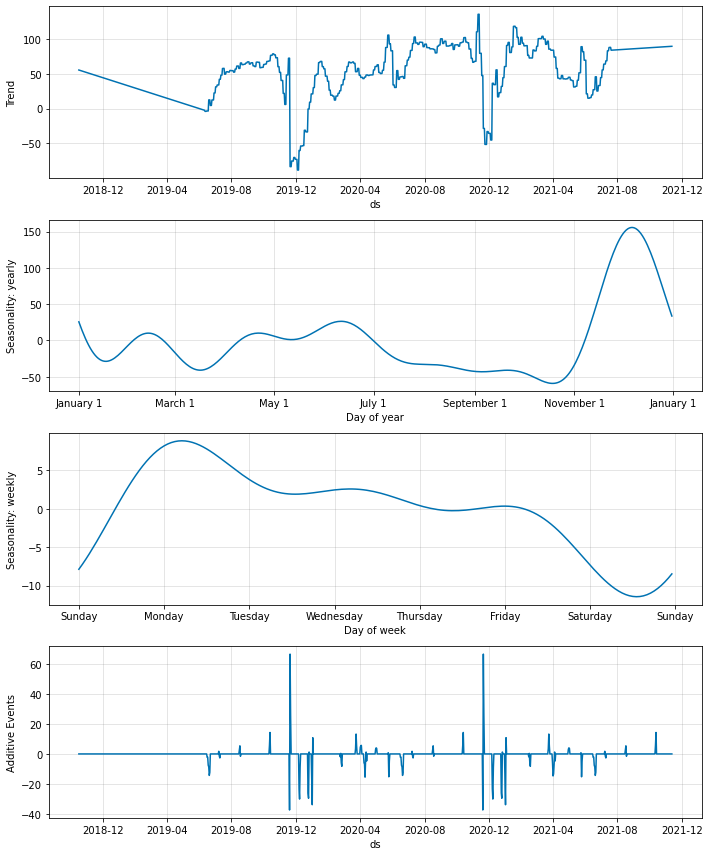

In [51]:
components_1= model_1.plot_components(preds_df_1)

Observamos las tendencias identificadas por el modelo que no son ajenas a las tendencias observadas durante la fase de exploración. Observamos que existe una tendencia a aumentar la cantidad de unidades vendidas sobre fin de año, especificamente Noviembre y Diciembre. Además, los lunes son los dias con mayor cantidad de ventas y luego disminuye de forma gradual para el resto de la semana, siendo el domingo el dia con menor volumen de ventas. 

#### Modelo: CATEG-2

In [52]:

m = NeuralProphet(
    impute_missing= True,
    n_forecasts=30,
    growth='discontinuous',
    n_changepoints=300,
    yearly_seasonality=True,
    weekly_seasonality= True,
    daily_seasonality=False,
    seasonality_mode="additive", 
    batch_size=84,
    epochs=150,
    learning_rate=1,
    )

m= m.add_country_holidays("ARG", mode="additive", lower_window=-1, upper_window=1)


preds_df_2, metrics_2, model_2= modelado_neural_prophet(df_2, 'CATEG-1', m)

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\utils.py:205: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Pyth

Cantidad de entradas train: 616 
 Cantidad de entradas test: 263


Epoch[150/150]: 100%|██████████| 150/150 [00:03<00:00, 40.35it/s, SmoothL1Loss=0.000962, MAE=4.5, RMSE=7.3, RegLoss=0, MAE_val=5.38, RMSE_val=7.82, SmoothL1Loss_val=0.00107]  
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.351% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major fr

NeuralProphet CATEG-1 MSE:	61.0955


In [53]:
metrics_2

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.716339,187.372973,243.551247,0.0,0.594769,162.254929,214.192444
1,0.493688,144.079586,190.605912,0.0,0.360192,116.825546,155.072525
2,0.289464,100.733472,137.401358,0.0,0.167315,74.745392,99.057922
3,0.119262,62.080891,82.769268,0.0,0.071694,49.849606,64.012497
4,0.064123,47.175880,60.327175,0.0,0.064245,45.903667,60.581173
...,...,...,...,...,...,...,...
145,0.000968,4.506999,7.414124,0.0,0.001071,5.377369,7.821262
146,0.000965,4.503936,7.380987,0.0,0.001070,5.374799,7.819109
147,0.000963,4.502054,7.306650,0.0,0.001070,5.375877,7.817331
148,0.000963,4.502788,7.294241,0.0,0.001070,5.375394,7.816473


In [54]:
performance_plot(preds_df_2,df_2,  'CATEG-2')

En la categoría 2, vemos como el modelo entrenado se ajusta a las tendencias, de forma de identificar con éxito las fluctuaciones en la cantidad de unidades vendidas. Vemos que identifica los dos períodos, abril del 2020 y marzo del 2021, donde se dan los mayores volumenes de venta. Además, el modelo logra reflejar los comportamientos de los datos tanto en el training como en la fase de test ya que se ajusta a los valores de la realidad. Si bien, al observar solo los datos de training podriamos decir que se produce overfitting, al observar el test que posee una distribucion diferente al sample anterior, evidenciamos que efectivamente el modelo logro captar las tendencias y ciclos llegando a predicciones sólidas y consistentes con la información. 

##### MAE Plot

In [55]:
MAE_plot(metrics_2, 'CATEG-2')

#### Model Decomposition CATEG-2

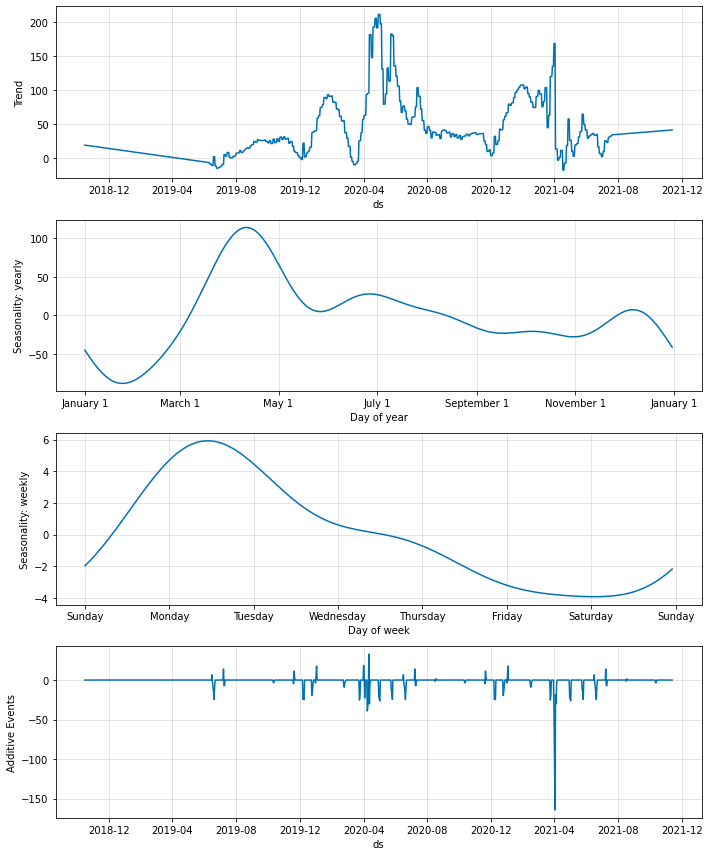

In [56]:
components_2= model_2.plot_components(preds_df_2)

A partir de la función decomposition del modelo, logramos observar que conclusiones obtuvo del set de datos. Los patrones identificados son coherentes con los vistos en la primer sección, donde observamos que se producen dos grandes saltos en los volúmenes de ventas representados como 'picos' en el periodo de abril del 2020 y marzo del 2021, y que alejado de esos periodos los volumene poseen fluctuaciones minimas. Además, de acuerdo con el modelo los días con mayor cantidad de ventas son al comienzo de la semana (lunes y martes) mientras que cerca del fin de semana esos valores disminuyen significativamente. Asimismo, los dias festivos influyen en la predisposición de compra del consumidor por lo que se refleja en variaciones en el volumen de ventas. 

#### Modelo: CATEG-3

In [57]:
m = NeuralProphet(
    impute_missing= True,
    n_forecasts=10,
    growth='discontinuous',
    n_changepoints=300,
    yearly_seasonality=True,
    weekly_seasonality= True,
    daily_seasonality=False,
    seasonality_mode="additive", 
    batch_size=24,
    epochs=150,
    learning_rate=1,
    )

m= m.add_country_holidays("ARG", mode="additive", lower_window=-1, upper_window=1)


preds_df_3, metrics_3, model_3= modelado_neural_prophet(df_3, 'CATEG-3', m)

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.022% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.022% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\utils.py:205: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Pyth

Cantidad de entradas train: 644 
 Cantidad de entradas test: 276


Epoch[150/150]: 100%|██████████| 150/150 [00:08<00:00, 17.20it/s, SmoothL1Loss=0.0032, MAE=111, RMSE=188, RegLoss=0, MAE_val=176, RMSE_val=361, SmoothL1Loss_val=0.00798]             
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.602% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.022% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.022% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to m

NeuralProphet CATEG-3 MSE:	130399.5181


In [58]:
metrics_3

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.514767,2476.232739,3252.576205,0.0,0.249685,1540.834961,2078.811523
1,0.102578,926.566671,1239.193493,0.0,0.030783,512.314636,709.475586
2,0.022937,460.954400,590.077735,0.0,0.021501,387.610260,596.523865
3,0.009746,274.171691,369.719057,0.0,0.012652,269.526764,461.429871
4,0.006720,207.707296,301.951825,0.0,0.013534,277.477753,479.977112
...,...,...,...,...,...,...,...
145,0.003275,111.216903,193.064927,0.0,0.007986,174.640091,361.591370
146,0.003257,110.521730,186.273475,0.0,0.008000,173.058197,362.412048
147,0.003211,110.587649,183.728969,0.0,0.007979,176.098816,361.070557
148,0.003209,110.946376,191.098548,0.0,0.007983,176.209793,361.116791


In [59]:
performance_plot(preds_df_3,df_3, 'CATEG-3')

Para la categoría 3 observamos como el modelo se ajusta a los valores reales logrando identificar las variaciones en el comportamiento del volumen de ventas. Además, observamos como tanto para la fase de train como la de test, logra capturar las fluctuaciones, a excepción de los últimos dos valores que se deben a una irregularidad o al inicio de una nueva tendencia. Sin embargo, para la cantidad de entradas del set de entrenamiento logro predecir de forma acertada las tendencias y ciclos de las unidades de venta. 

In [60]:
MAE_plot(metrics_3, 'CATEG-3')

#### Model Decomposition CATEG-3

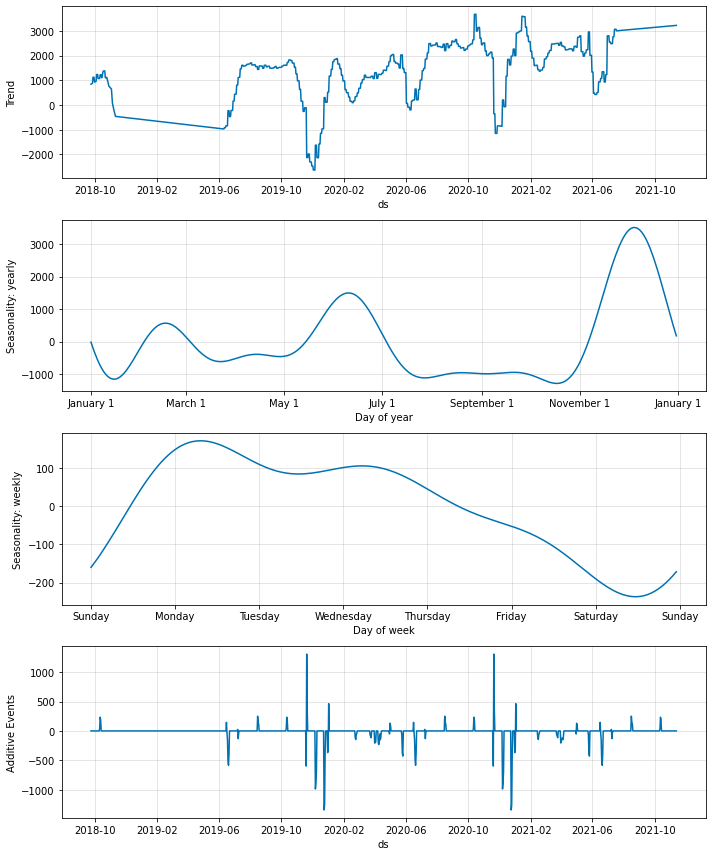

In [61]:
components_3= model_3.plot_components(preds_df_3)

En la descomposición del modelo observamos que la medida de tendencia imita el comportamiento de los datos pero de una forma exagerada ya que identifica las caidas de las unidades vendidas de forma mas pronunciada, mientras que en la gráfica observamos caidas de no más de 500 unidades en las tendencias se presentan como mayores a 1000. Sin embargo, en las tendencias mensuales logra identificar con éxito los ciclos de las ventas, pronosticando que en mayo y noviembre se producen aumentos en las ventas, con un gradual creciemiento a lo largo de todo el año. Asimismo, para las tendencias semanales, observamos que los lunes y martes aumenta el volumen de ventas y decae de forma paulatina durante la semana, el mayor decrecimiento comienza los jueves hasta el fin de semana que vuelve a comenzar el ciclo. 

### PARTE 3: Predicciones para los próximos 21 días <a id='3'></a>

CATEG -1 

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.775% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




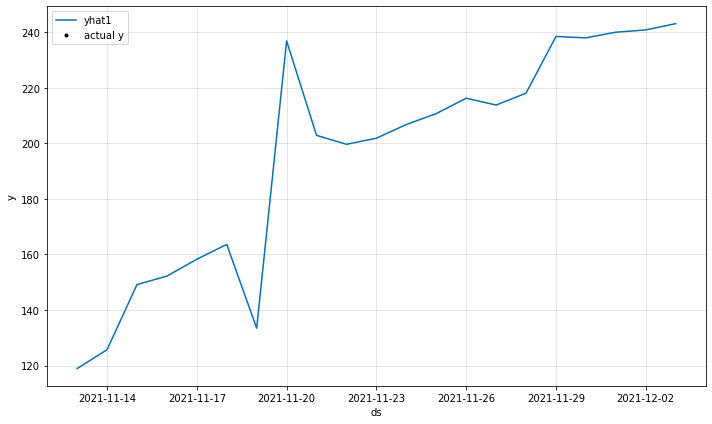

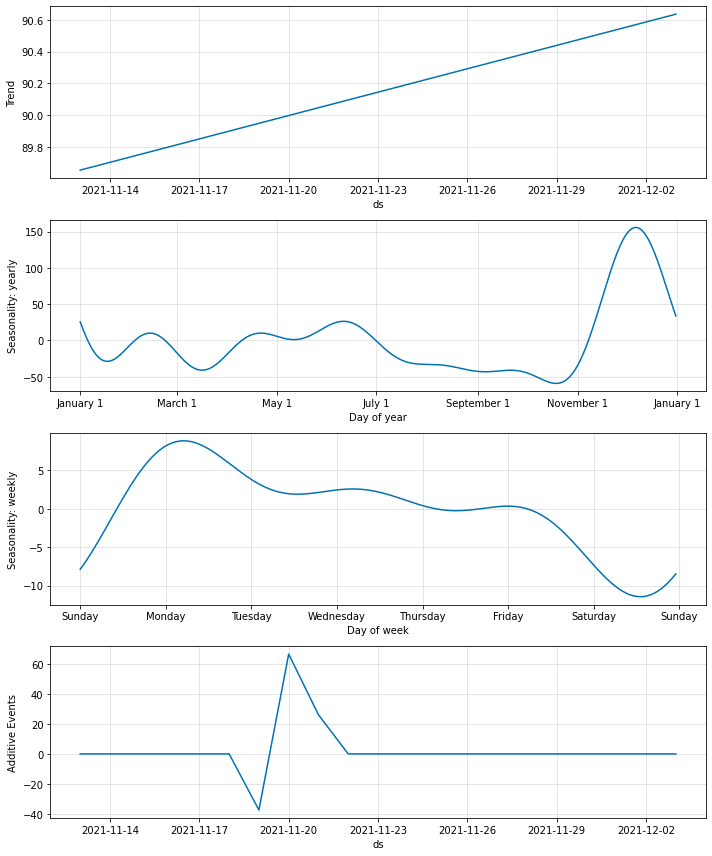

In [62]:
future = model_1.make_future_dataframe(df_1, periods=21)
forecast_1 = model_1.predict(future)
fig_forecast1 = model_1.plot(forecast_1)
fig_comp1 = model_1.plot_components(forecast_1)

CATEG- 2

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




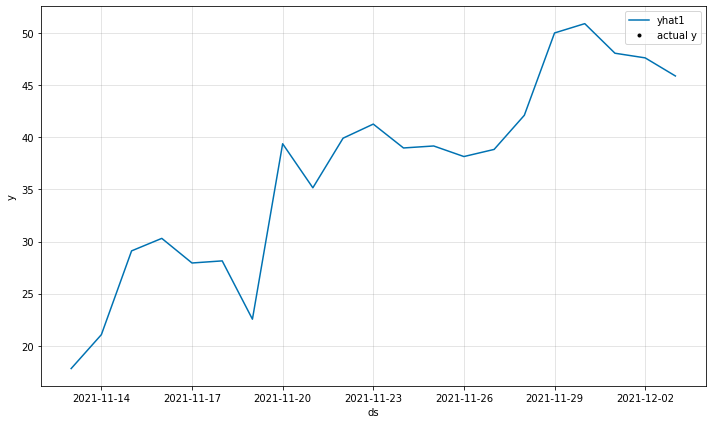

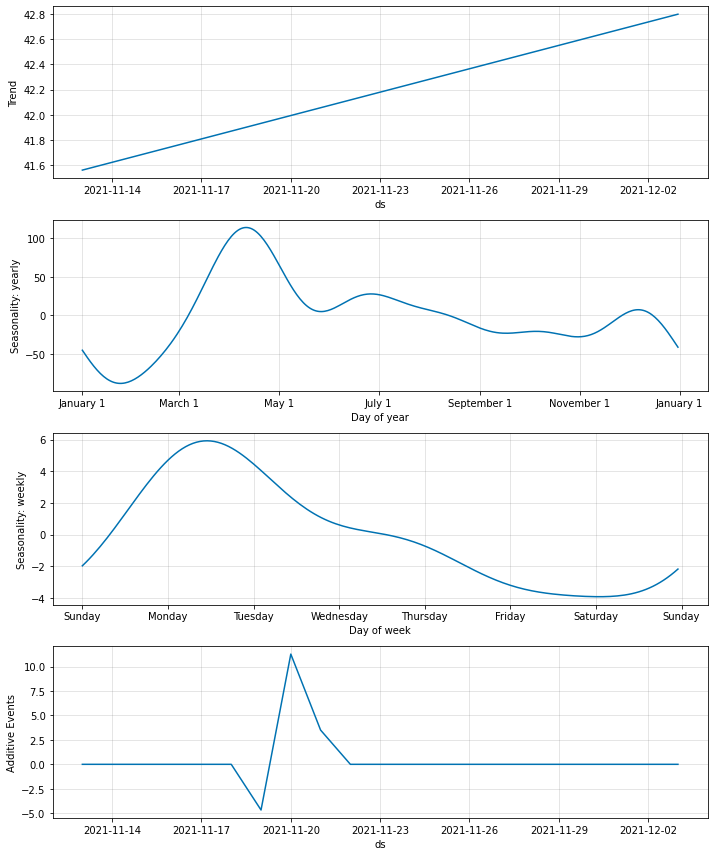

In [63]:
future2 = model_2.make_future_dataframe(df_2, periods=21)
forecast_2 = model_2.predict(future2)
fig_forecast2 = model_2.plot(forecast_2)
fig_comp2 = model_2.plot_components(forecast_2)

CATEG- 3

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.022% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Bravo15\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




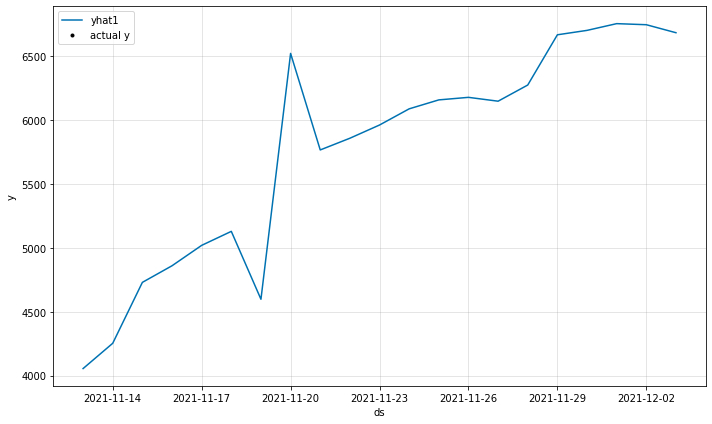

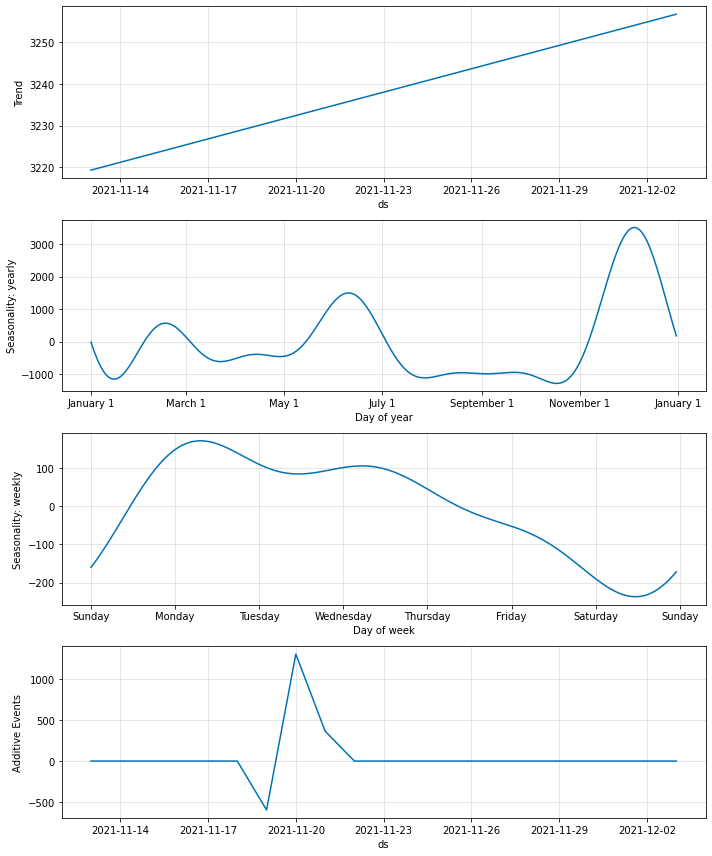

In [64]:
future3 = model_3.make_future_dataframe(df_3, periods=21)
forecast_3 = model_3.predict(future3)
fig_forecast3 = model_3.plot(forecast_3)
fig_comp3 = model_3.plot_components(forecast_3)

#### Creamos el df con el forecast para cada categoría 

In [65]:

data = {'fecha': forecast_1.ds,
        'CATEG-1': forecast_1.yhat1, 
        'CATEG-2': forecast_2.yhat1, 
        'CATEG-3': forecast_3.yhat1}

forecast_21_day= pd.DataFrame.from_dict(data)


In [66]:
forecast_21_day

,fecha,CATEG-1,CATEG-2,CATEG-3
0,2021-11-13,118.903839,17.823471,4055.358154
1,2021-11-14,125.703247,21.073332,4253.331543
2,2021-11-15,149.164627,29.104368,4730.351562
3,2021-11-16,152.216629,30.302801,4860.431152
4,2021-11-17,158.288986,27.942863,5020.151855
5,2021-11-18,163.624512,28.144680,5129.765625
6,2021-11-19,133.441025,22.556538,4598.125977
7,2021-11-20,236.957520,39.373180,6523.386230
8,2021-11-21,202.925964,35.150803,5767.478027
9,2021-11-22,199.705078,39.907021,5859.103516


### Conclusión <a id='intro'></a>

En este ejercicio logramos identificar el comportamiento del volumen de ventas para cada categoría utilizando el modelo Neural Prophet. Los tres modelos, no solo predicen sino que permiten obtener información adicional sobre los ciclos, y tendencias de los períodos de venta y de que forma se reflejan en las cantidades vendidas. Permitiendo un equilibrio entre performance e interpretación de los resultados. La arquitectura del modelo permite escalar el volumen de datos, y optimizar las predicciones a partir de ellos. Para los tres modelos el margen de error es mínimo, permitiéndonos seguir ajustando los parámetros para cada uno de ellos de ser necesario.  Considero que los tres modelos logran predicir de forma efectiva las ventas para los próximos 21 días ya que se obtienen resultados precisos y coherentes con la información. 